In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import sympy as sym 
import random as rand
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import qexpy as q
from scipy import integrate
from scipy.integrate import odeint

# Rungekutta - Bashford - Moulton

### ¡¡PRUEBA!!

In [14]:
def System(r,t,mu=1.5):
    
    x,vx = r
    
    dxdt = vx
    dvxdt = mu*(1-x**2)*vx - x
    
    return np.array([dxdt,dvxdt])

In [15]:
t = np.linspace(0,20,10000)
r0 = [0.5,0.]

In [16]:
sol = odeint(System, r0, t, args=(1.3,))

In [17]:
def IntegratorAdams(f,r0,t,mu):
    
    h = t[1] - t[0]
    
    x = np.zeros_like(t)
    #y=np.zeros_like(t)
    vx = np.zeros_like(t)
    #vy=np.zeros_like(t)
    
    x[0] = r0[0]
    #y[0]=r0[1]
    vx[0] = r0[1]#Pasar a 2
    #vy[0]=r0[3]

    #Dos dimensiones pasar a 4
    K11 = np.zeros(2)
    K12 = np.zeros(2)
    K13 = np.zeros(2)
    K14 = np.zeros(2)
    
    # Euler
    x[1] = x[0] + h*K11[0]
    #y[1]=y[0]+h*K11[1]
    vx[1] = vx[0] + h*K11[1]#Pasar K11 a 2 si 2D
    #vy[1] = vy[0] + h*K11[3]
    
    for i in range(1,4):
        present = np.array([x[i-1],vx[i-1]]) #agragar np.array([x[i-1],y[i-1],vx[i-1],vy[i-1]])
        K11 = f(present,t[i-1],mu)
        K12 = f(present+0.5*K11*h,t[i-1]+0.5*h,mu)
        K13 = f(present+0.5*K12*h,t[i-1]+0.5*h,mu)
        K14 = f(present+K13*h,t[i-1]+h,mu)
        x[i] = x[i-1] + h*(K11[0]+2*K12[0]+2*K13[0]+K14[0])/6
        #y[i] = y[i-1] + h*(K11[1]+2*K12[1]+2*K13[1]+K14[1])/6
        vx[i] = vx[i-1] + h*(K11[1]+2*K12[1]+2*K13[1]+K14[1])/6 #pasar a K--[2]
        #vy[i] = vy[i-1] + h*(K11[3]+2*K12[3]+2*K13[3]+K14[3])/6


    
    
    
    xc = x.copy()
    #yc=y.copy()
    vxc = vx.copy()
    #vyc = vy.copy()
    
    for i in range(4,len(t)):
        
        present = np.array([x[i-1],vx[i-1]]) #np.array([x[i-1],y[i-1],vx[i-1],vy[i-1]])
        past = np.array([x[i-2],vx[i-2]])#np.array([x[i-2],y[i-2],vx[i-2],vy[i-2]])
        past2=np.array([x[i-3],vx[i-3]]) #np.array([x[i-3],y[i-3],vx[i-3],vy[i-3]])
        past3=np.array([x[i-4],vx[i-4]]) #np.array([x[i-4],y[i-4],vx[i-4],vy[i-4]])
        K11 = f(present,t[i-1],mu)
        K12 = f(past,t[i-2],mu)
        K13 = f(past2,t[i-3],mu)
        K14 = f(past3,t[i-4],mu)
        
        x[i] = x[i-1] + h*(55*K11[0] - 59*K12[0] + 37*K13[0] -9*K14[0])/24
        #y[i] = y[i-1] + h*(55*K11[1] - 59*K12[1] + 37*K13[1] -9*K14[1])/24

        vx[i] = vx[i-1] + h*(55*K11[1] - 59*K12[1] + 37*K13[1] -9*K14[1])/24 #Cambiar a2
        #vy[i] = vy[i-1] + h*(55*K11[3] - 59*K12[3] + 37*K13[3] -9*K14[3])/24 
        

        
        xc[i] = x[i]
        #yc[i] = y[i]
        
        vxc[i] = vx[i]
        #vyc[i] = vy[i]
        
        # Futuro
        futuro = np.array([x[i],vx[i]]) #np.array([x[i],y[i],vx[i],vy[i]])
        K15 = f(futuro,t[i],mu)
        
        xc[i] = xc[i-1] + h*(251*K15[0] + 646*K11[0] -264*K12[0] + 106*K13[0] - 19*K14[0])/720
        #yc[i] = yc[i-1] + h*(251*K15[1] + 646*K11[1] -264*K12[1] + 106*K13[1] - 19*K14[1])/720
        vxc[i] = vxc[i-1] + h*(251*K15[1] + 646*K11[1] -264*K12[1] + 106*K13[1] - 19*K14[1])/720 #Pasar a 2
        #vyc[i] = vyc[i-1] + h*(251*K15[3] + 646*K11[3] -264*K12[3] + 106*K13[3] - 19*K14[3])/720
    

    
    return x,vx,xc,vxc #x,y,vx,vy,xc,yc,vxc,vyc

In [18]:

sol2 = IntegratorAdams(System,r0,t,1.3)

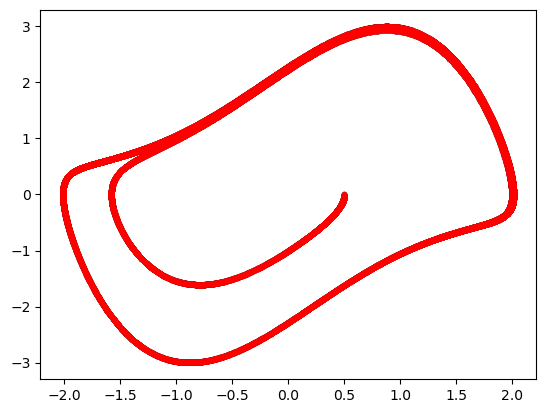

In [21]:
#plt.scatter(sol2[0],sol2[1],color='r')
plt.scatter(sol2[2],sol2[3],marker='.',color='k')
plt.scatter(sol[:,0],sol[:,1],marker='.',color="red")

# Adaptativo Vectorizado

In [6]:
def System(r,t,mu=1.3):
    
    x,vx = r
    
    dxdt = vx
    dvxdt = mu*(1-x**2)*vx - x
    
    return np.array([dxdt,dvxdt])

In [7]:

t = np.linspace(0,20,100)
r0 = np.array([0.5,0.])

sol = odeint(System, r0, t, args=(1.3,))


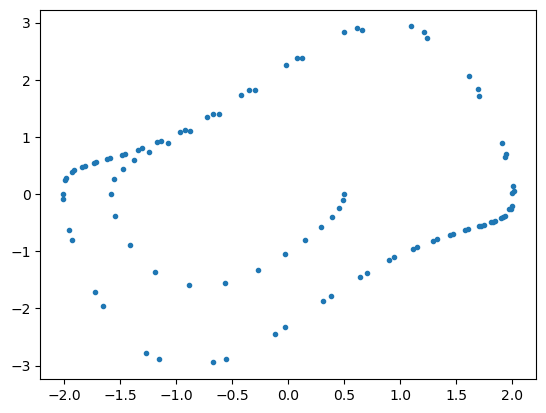

In [8]:
plt.scatter(sol[:,0],sol[:,1],marker='.')

In [9]:
def Increment(f,r,t,h):
    
    state1 = np.array([r[0],r[1]])
    K1 = f(state1,t)
    
    state2 = np.array([r[0]+0.5*h*K1[0],r[1]+0.5*h*K1[1]])
    K2 = f(state2,t+0.5*h)
    
    state3 = np.array([r[0]+0.5*h*K2[0],r[1]+0.5*h*K2[1]])
    K3 = f(state3,t+0.5*h)
    
    state4 = np.array([r[0]+h*K3[0],r[1]+h*K3[1]])
    K4 = f(state4, t+h)
    
    Deltaf = h*(K1+2*K2+2*K3+K4)/6
    
    return r+Deltaf

In [10]:
def CheckStep(Delta1,Delta2,Delta3,h,minimo=1e-2,maximo=1e-1):
    
    tolerancia = 0.001
    
    Delta1 = np.abs(Delta1)
    Delta2 = np.abs(Delta2)
    Delta3 = np.abs(Delta3)
    
    if Delta1 < tolerancia:
        h = minimo
        dx = Delta1
        
    else:
        
        if np.abs((Delta1 - Delta2))/Delta1 > maximo:
            h = 0.5*h
            dx = Delta2
        
        elif np.abs((Delta1-Delta3))/Delta1 < minimo:
            h = 2*h
            dx = Delta3
        
        else:
            dx = Delta1
            
    return dx,h

In [11]:
def Adaptativo(f,x0,t):
    
    h = t[1] - t[0]
    
    tf = t[-1]
    t = t[0]
    
    r = r0
    
    Time = np.array([t])
    Vector = r
    
    Steps = np.array([h])
    
    while t < tf:
        
        Delta1 = Increment(f,r,t,h)
        Delta2 = Increment(f,r,t,0.5*h)
        Delta3 = Increment(f,r,t,2*h)
    
        Deltas = Delta1.copy()
        ht = Delta1.copy()
        
        for i in range(Delta1.shape[0]):
            Deltas[i],ht[i] = CheckStep(Delta1[i],Delta2[i],Delta3[i],h)
    
    
        h = np.mean(ht)
        t += h
        
        r = Increment(f,r,t,h)
        
        
        Steps = np.append(Steps,h )
        Time = np.append(Time,t)
        Vector = np.vstack((Vector,r))
        
    return Time,Vector,Steps


In [12]:
t1,x1,h1 = Adaptativo(System,r0,t)

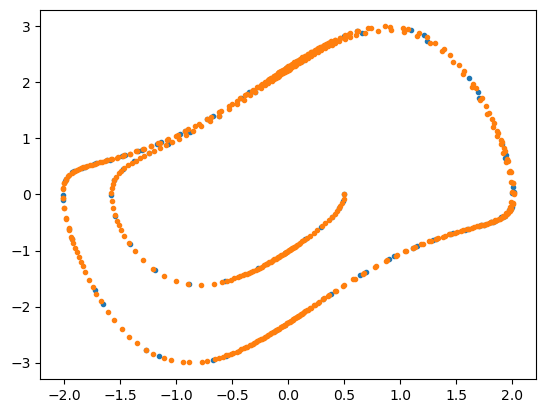

In [13]:
plt.scatter(sol[:,0],sol[:,1],marker='.')
plt.scatter(x1[:,0],x1[:,1],marker='.')